In [1]:
# import sys
# sys.path.append('..')

In [2]:
from utility import load_dataset, load_model_with_ckpt, make_one_graph
import draw_utils

/opt/miniconda3/envs/SPGIE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torchvision.transforms as VT
from torchvision.datasets import MNIST
ori_dataset = MNIST('~/data', train=False, transform=VT.ToTensor())
dataset = load_dataset('mnist', train=False)

----- Loading test dataset -----


In [4]:
# hidden_dim = 20
# ckpt_name = '/home/dragonchen/SPGIE_thesis/mlruns/0/1c9779a75ea94423be73437ac34200df/artifacts/best.pt'
hidden_dim = 64
ckpt_name = '/home/dragonchen/SPGIE_thesis/mlruns/0/5e3d764e3cf548efb10a5713c76999e4/artifacts/best.pt'

aggr = 'add'
pool = 'max'

device = torch.device('cpu')
model = load_model_with_ckpt(
    input_dim=dataset.num_features,
    hidden_dim=hidden_dim,
    output_dim=dataset.num_classes,
    drn_k=4, aggr=aggr, pool=pool,
    device=device,
    ckpt_name=ckpt_name,
)

Pooling with max
Using self-loops
There are 2 aggregation layers


In [5]:
img_idx = 9
img_ori, lbl = ori_dataset[img_idx]
img_sp, node2map = make_one_graph(
    torch.permute(img_ori, (1, 2, 0)), channel_axis=None,
)
img_sp.y = torch.tensor(lbl)

seg (28, 28)


In [6]:
img_ori.shape

torch.Size([1, 28, 28])

In [7]:
# temp = dataset[0]
# temp = img_sp
# print(temp.x.dtype)
# print(temp.edge_index.dtype)
# print(temp.y.dtype)
# print(temp.pos.dtype)

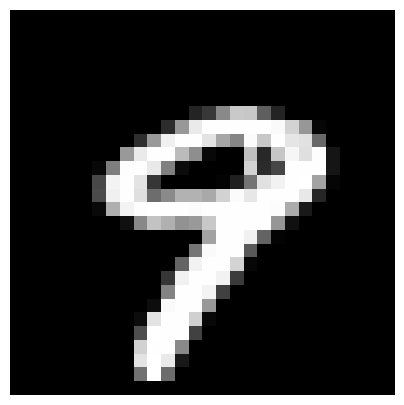

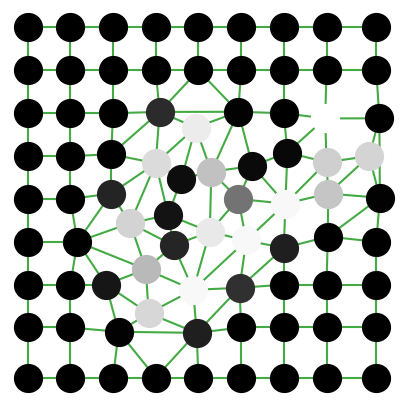

In [8]:
import matplotlib.pyplot as plt

# original
draw_utils.show_original(img_ori)

# superpixel version
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, img_sp.x[:, 2].unsqueeze(dim=1),
    img_sp.edge_index,
)
plt.show()

In [9]:
img_sp.batch = torch.zeros(img_sp.x.shape[0]).long()
img_sp = img_sp.to(device)

out = model(img_sp).detach().cpu()

print('true', lbl)
print('pred', out.argmax(1).item())

true 9
pred 9


In [10]:
# torch.manual_seed(1340)
for i, c in enumerate(torch.softmax(out, 1).tolist()[0]):
    print(f'{i} {c:.04f}')

0 0.0000
1 0.0000
2 0.0000
3 0.0000
4 0.0146
5 0.0000
6 0.0000
7 0.0019
8 0.0000
9 0.9835


## Start Explaining

In [11]:
from PIL import Image
plt.rcParams['figure.facecolor'] = '#fffafa'
import networkx as nx
from skimage.segmentation import slic, mark_boundaries

In [12]:
from models.jit_drn_model import (
    knn_graph, to_undirected, normalized_cut_2d,
    graclus_cluster,
#     aggr_pool, aggr_pool_x,
    global_pool_aggr
)

In [13]:
from torch_scatter import scatter
from torch_geometric.typing import OptTensor, Optional, Tuple
from torch import Tensor
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool.pool import pool_batch

def _aggr_pool_x(cluster, x, aggr: str, size: Optional[int] = None):
    """Call into scatter with configurable reduction op"""
    return scatter(x, cluster, dim=0, dim_size=size, reduce=aggr)

def global_pool_aggr(x, batch: OptTensor, aggr: str, size: Optional[int] = None):
    """Global pool via passed aggregator: 'mean', 'add', 'max'"""
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if batch is not None:
        size = int(batch.max().item() + 1)
    assert batch is not None
    return scatter(x, batch, dim=0, dim_size=size, reduce=aggr)

# this function is specialized compared to the more general non-jittable version
# in particular edge_attr can be removed since it is always None
def aggr_pool(cluster, x, batch: OptTensor, aggr: str) -> Tuple[Tensor, OptTensor]:
    """jit-friendly version of max/mean/add pool"""
    global node_hist
    print('c1', cluster.shape)
    print(cluster[:20])
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster[:20])
    print('perm', perm.shape)
    print('perm', perm[:10])
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })

    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)
    return x, batch

def aggr_pool_x(cluster, x, batch: OptTensor, aggr: str, size: Optional[int] = None) -> Tuple[Tensor, OptTensor]:
    """*_pool_x with configurable aggr method"""
    global node_hist
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if size is not None and batch is not None:
        batch_size = int(batch.max().item()) + 1
        return _aggr_pool_x(cluster, x, aggr, batch_size * size), None

    print('c1', cluster.shape)
    print(cluster)
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster)
    print('perm', perm.shape)
    print('perm', perm)
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })
    
    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)

    return x, batch

start x torch.Size([81, 64])
c1 torch.Size([81])
tensor([ 0,  0,  2,  2,  4,  5,  6,  7,  7,  9, 10, 11, 12,  4,  5,  6, 16, 17,
        18, 10])
c2 torch.Size([81])
tensor([ 0,  0,  1,  1,  2,  3,  4,  5,  5,  6,  7,  8,  9,  2,  3,  4, 10, 11,
        12,  7])
perm torch.Size([44])
perm tensor([ 1,  3, 13, 14, 15,  8,  9, 19, 20, 21])


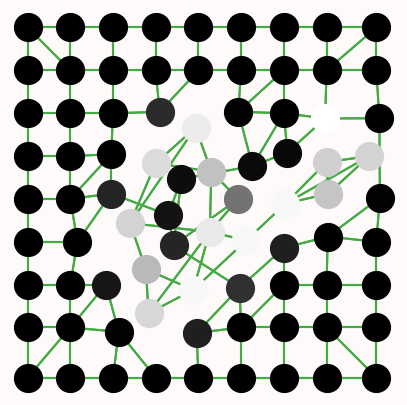

c1 torch.Size([44])
tensor([ 0,  0,  2,  2,  4,  5,  6,  7,  8,  8, 10, 10,  6, 13, 14, 15, 16, 15,
        13, 19,  5, 16, 22, 23, 24, 25, 26, 24, 28, 23, 30, 25, 28, 33, 26, 35,
        36, 36, 38, 35, 40, 41, 40, 38])
c2 torch.Size([44])
tensor([ 0,  0,  1,  1,  2,  3,  4,  5,  6,  6,  7,  7,  4,  8,  9, 10, 11, 10,
         8, 12,  3, 11, 13, 14, 15, 16, 17, 15, 18, 14, 19, 16, 18, 20, 17, 21,
        22, 22, 23, 21, 24, 25, 24, 23])
perm torch.Size([26])
perm tensor([ 1,  3,  4, 20, 12,  7,  9, 11, 18, 14, 17, 21, 19, 22, 29, 27, 31, 34,
        32, 30, 33, 39, 37, 43, 42, 41])
global x tensor([[ -2.9435,   1.2473,  -2.2833,  12.4087,   0.4243,  17.4249,  -2.5683,
          -1.5331,  37.4969,  29.8431,  51.4956,   2.0341,   6.6068,   2.4417,
          -2.9246,  -3.8447,  26.8399,  -2.3369,  -1.0994,  25.0223,   0.2122,
          34.4416,  -3.5425,  17.7188,  30.2607,   6.8325,   3.2644,  19.1717,
          24.0365,  -1.3719,   9.1122,  -2.0906,  31.3642,  16.9989,  10.5623,
      

[[-26.114620208740234,
  -12.896827697753906,
  -15.241227149963379,
  -17.524124145507812,
  -5.544219970703125,
  -13.712830543518066,
  -17.653722763061523,
  -6.0763750076293945,
  -11.731921195983887,
  -0.006237800233066082]]

In [14]:
import torch.nn.functional as F

torch.manual_seed(100)

drn = model.drn # get the model layer
x = img_sp.x
batch = img_sp.batch

# draw_superpixel_from_graph(x, gd.edge_index)

x = drn.datanorm * x
x = drn.inputnet(x)

nAgg = len(drn.agg_layers)

node_hist = []
print(f'start x', x.shape)
node_hist.append({'x': x.detach().cpu()})
for i, edgeconv in enumerate(drn.agg_layers):
    knn = knn_graph(x, drn.k, batch, loop=drn.loop, flow=edgeconv.flow)
#     print(f'i {i} knn', knn.shape)
    edge_index = to_undirected(knn)
#     print(x.T)
#     plot_x(x)
    x = edgeconv(x, edge_index)
#     print(x.T)
#     plot_x(x)
    
#     print(f'i {i} edge conv', x.shape)

    weight = normalized_cut_2d(edge_index, x)
    cluster = graclus_cluster(edge_index[0], edge_index[1], weight, x.size(0))
#     print(f'i {i} cluster', cluster.shape)

    if i == nAgg - 1:
        x, batch = aggr_pool_x(cluster, x, batch, drn.aggr_type)
    else:
        x, batch = aggr_pool(cluster, x, batch, drn.aggr_type)
    
    # extract history node
#     hist = cluster.tolist()
# #     print('h', hist)
#     node_hist.append(torch.tensor(hist))
    xx = img_sp.x.cpu()
    ee = edge_index.cpu()
#     print('h', hist)
#     print('ee', ee)
    node_hist.append({'x': x.detach().cpu()})
    
    if i == 0:
        draw_utils.draw_superpixel_from_graph(
            xx[:, :2], xx[:, 2:], ee
        )


# print('b', batch)
x = global_pool_aggr(x, batch, drn.aggr_type)
print('global x', x)
node_hist.append({'global_x': x.detach().cpu()})

# print(f'global x', x.shape)

out = drn.output(x).squeeze(-1)
out = F.log_softmax(out, dim=1)
out.tolist()

In [15]:
# print([n.keys() for n in node_hist])
# for n in node_hist:
#     print('-----layer-----')
#     for k in n:
#         print(k, n[k].shape)

In [16]:
from collections import defaultdict
counter = defaultdict(int)
gx = node_hist[-1]['global_x']
for i, g in enumerate(gx.tolist()[0]):
    if g > 1:
        xx2 = node_hist[-2]['x']
        xx2k = xx2[:, i].tolist().index(g)
        print(xx2k)
        counter[xx2k] += 1
print('counter', counter)

12
18
11
10
18
10
18
10
10
11
10
10
12
18
18
10
18
12
10
18
11
10
12
11
11
11
10
10
18
11
11
11
18
11
12
10
10
11
12
18
11
10
21
11
10
counter defaultdict(<class 'int'>, {12: 6, 18: 10, 11: 13, 10: 15, 21: 1})


In [17]:
l1 = node_hist[1]
l2 = node_hist[3]

nodes = [n for n in counter if counter[n] >= 2]
nodes

[12, 18, 11, 10]

In [18]:
nodes_l2 = []
for n in nodes:
    idx = l2['p'][n].item() # put node-num get cluster idx
    print(idx)
    c = l2['c2'][idx].item() # extract original node-num from cluster idx
    print('c', c)
    nodes = torch.arange(len(l2['c2']))[l2['c2'] == c].tolist()
    print('nodes', nodes)
    
    nodes_l2 += nodes
nodes_l2

19
c 12
nodes [19]
32
c 18
nodes [28, 32]
21
c 11
nodes [16, 21]
17
c 10
nodes [15, 17]


[19, 28, 32, 16, 21, 15, 17]

In [19]:
nodes_l1 = []
for n in nodes_l2:
    idx = l1['p'][n].item() # put node-num get cluster idx
    print(idx)
    c = l1['c2'][idx].item() # extract original node-num from cluster idx
    print('c', c)
    nodes = torch.arange(len(l1['c2']))[l1['c2'] == c].tolist()
    print('nodes', nodes)
    
    nodes_l1 += nodes
nodes_l1

43
c 19
nodes [32, 43]
50
c 28
nodes [50]
75
c 32
nodes [59, 75]
38
c 16
nodes [27, 38]
49
c 21
nodes [35, 49]
36
c 15
nodes [26, 36]
44
c 17
nodes [28, 44]


[32, 43, 50, 59, 75, 27, 38, 35, 49, 26, 36, 28, 44]

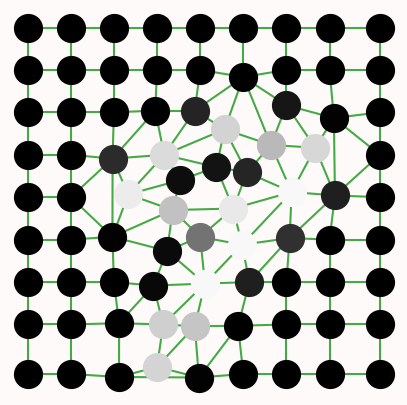

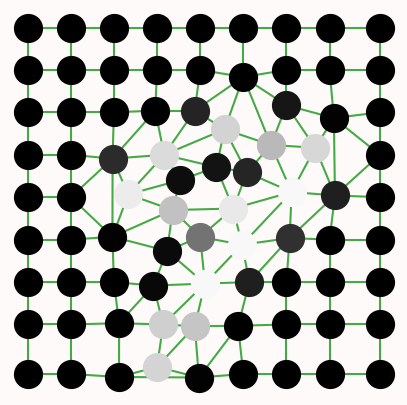

In [20]:
# use old function print
import numpy as np
pos = img_sp.x[:, :2].cpu().numpy()
pos = np.flip(pos, 1)
rgb = img_sp.x[:, 2].cpu().unsqueeze(1).numpy() * 255
draw_utils.draw_superpixel_from_graph(
    pos, rgb, img_sp.edge_index, multi_graph=False,
)

true 9
pred 9


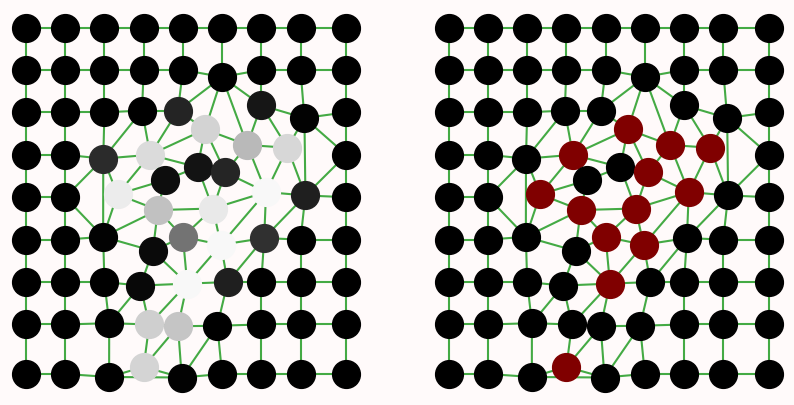

temp (3, 28, 28)


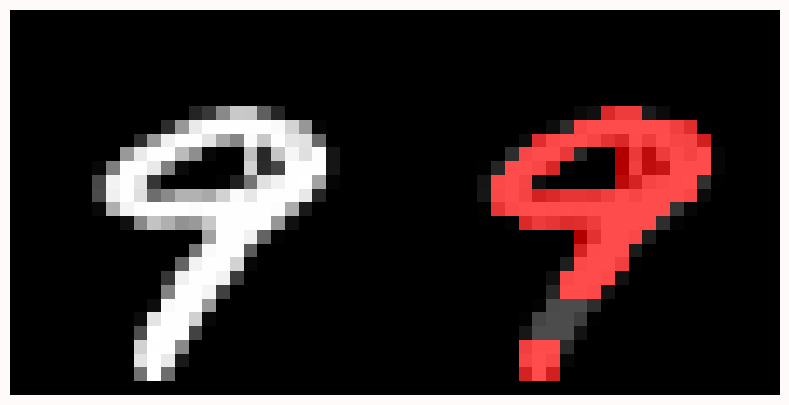

In [21]:
print('true', lbl)
print('pred', out.argmax(1).item())

# use old function print rgb and imp
pos = img_sp.x[:, :2].cpu().numpy()
pos = np.flip(pos, 1)
rgb = img_sp.x[:, 2].cpu().unsqueeze(1).numpy() * 255

imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
    imp[n][0] = 128

draw_utils.draw_superpixel_from_graph(
    pos, [rgb, imp], img_sp.edge_index,
    multi_graph=True,
)

img_temp = img_ori.numpy().copy()
img_temp = np.repeat(img_temp, 3, axis=0)
img_temp = img_temp * 0.3

print('temp', img_temp.shape)
for n in nodes_l1:
    m = node2map[n]
    img_temp[0, m] += 0.7

# img_temp = np.transpose(img_temp, (1, 2, 0))

img_ori_temp = np.repeat(img_ori, 3, axis=0)
img_out = np.concatenate([img_ori_temp, img_temp], axis=2)

draw_utils.show_original(img_out, width=15)